# Finetuning Segment Anything with `µsam`

This notebook shows how to use Segment Anything for Microscopy to fine-tune a Segment Anything Model (SAM) on your custom data.

### Importing the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components
import os
import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler
from torch_em.util.util import get_random_colors

import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

In [2]:
IMAGE_DIR = os.path.join("data/images")
LABEL_DIR = os.path.join("data/labels")

def get_dataloader(split, patch_shape, batch_size, train_instance_segmentation):
    """Return train or val data loader for finetuning SAM."""
    assert split in ("train", "val")
    os.makedirs(DATA_FOLDER, exist_ok=True)

    # Load images and labels
    raw_key, label_key = None, None
    
    # Split dataset: first 70% for training, remaining 30% for validation
    all_files = sorted(os.listdir(IMAGE_DIR))
    split_idx = int(0.7 * len(all_files))
    
    if split == "train":
        roi = np.s_[:split_idx]
    else:
        roi = np.s_[split_idx:]

    if train_instance_segmentation:
        label_transform = PerObjectDistanceTransform(
            distances=True, boundary_distances=True, directed_distances=False,
            foreground=True, instances=True, min_size=25
        )
    else:
        label_transform = torch_em.transform.label.connected_components

    loader = torch_em.default_segmentation_loader(
        raw_paths=IMAGE_DIR, raw_key=raw_key,
        label_paths=LABEL_DIR, label_key=label_key,
        patch_shape=patch_shape, batch_size=batch_size,
        ndim=2, is_seg_dataset=True, rois=roi,
        label_transform=label_transform,
        num_workers=8, shuffle=True, raw_transform=sam_training.identity,
    )
    return loader

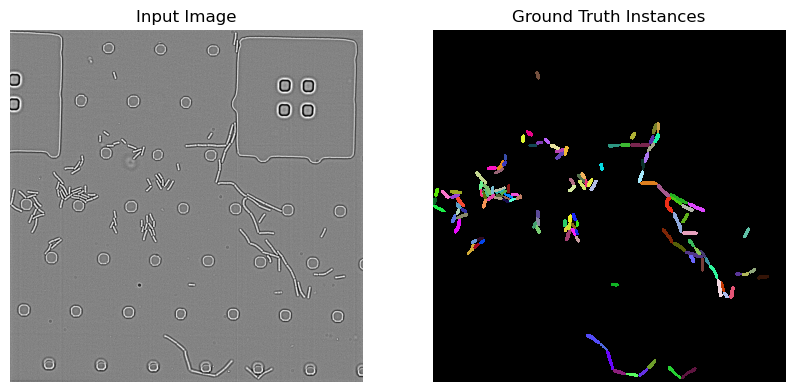

In [3]:
image_paths = sorted(glob(os.path.join(IMAGE_DIR, "*")))
segmentation_paths = sorted(glob(os.path.join(LABEL_DIR, "*")))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")

    plt.show()
    plt.close()

    break  # comment this out in case you want to visualize all the images

#### Next, let's create the dataloaders

In [4]:
# 'micro_sam.training.default_sam_loader' is a convenience function to build a pytorch dataloader from image data and labels for training segmentation models.
# This is wrapped around the 'torch_em.default_segmentation_loader'.
# It supports image data in various formats.
# Here, we load image data and labels from the two folders with tif images that were downloaded by the example data functionality,
# by specifying `raw_key` and `label_key` as `*.tif`.
# This means all images in the respective folders that end with .tif will be loaded.
# The function supports many other file formats. For example, if you have tif stacks with multiple slices instead of multiple tif images in a folder,
# then you can pass 'raw_key=label_key=None'.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md
# And here is a tutorial on creating dataloaders using 'torch-em': https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Alternative: if you have tif stacks you can just set 'raw_key' and 'label_key' to None
# raw_key, label_key= None, None

In [5]:
# The script below returns the train or val data loader for finetuning Segment Anything Model (SAM).
# The data loader must be a torch data loader that returns `x, y` tensors, where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive

# Here, we use `micro_sam.training.default_sam_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (512, 512)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
# NOTE 1: It's important to have densely annotated-labels while training the additional convolutional decoder.
# NOTE 2: In case you do not have labeled images, we recommend using `micro-sam` annotator tools to annotate as many objects as possible per image for best performance.
train_instance_segmentation = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# There are cases where our inputs are large and the labeled objects are not evenly distributed across the image.
# For this we use samplers, which ensure that valid inputs are chosen subjected to the paired labels.
# The sampler chosen below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
sampler = MinInstanceSampler(min_size=25)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

In [6]:
import imageio

img = imageio.imread("data/images/03_P2LDC4_1_T2-0001.tif")
print(img.shape)  # Check if it prints (height, width) or (height, width, channels)


(1024, 1024)


In [7]:
train_loader = sam_training.default_sam_loader(
    raw_paths=IMAGE_DIR,
    raw_key=raw_key,
    label_paths=LABEL_DIR,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=IMAGE_DIR,
    raw_key=raw_key,
    label_paths=LABEL_DIR,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
)

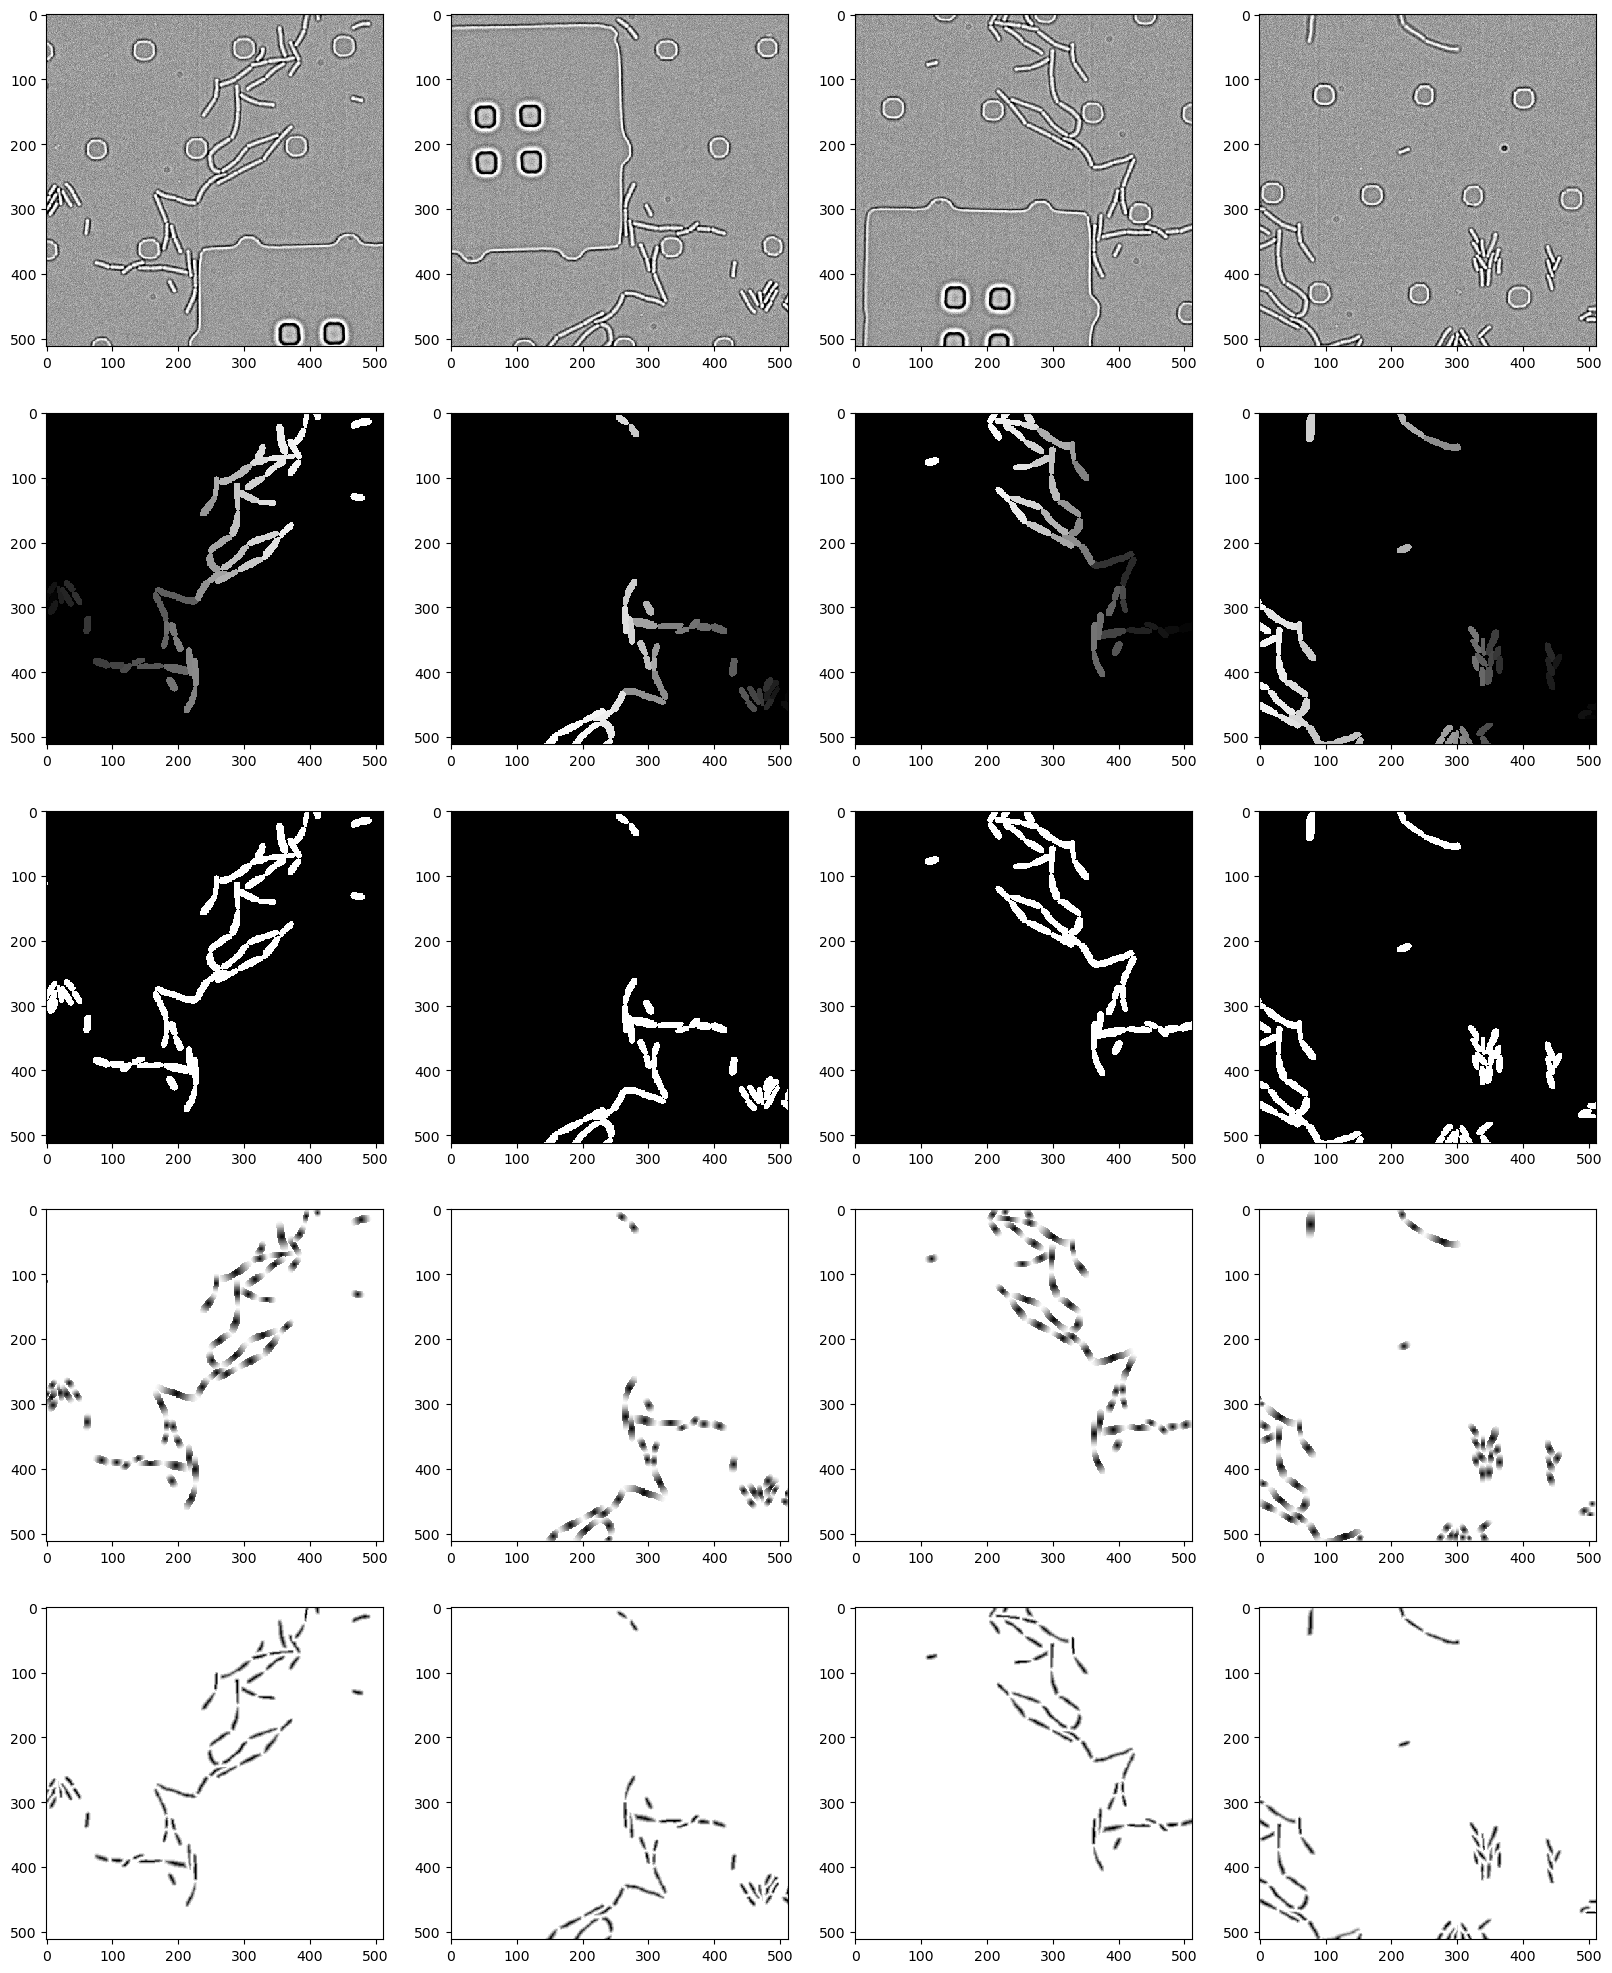

In [8]:
# Let's check how our samples look from the dataloader
check_loader(train_loader, 4, plt=True)

### Run the actual model finetuning

In [9]:
# All hyperparameters for training.
n_objects_per_batch = 5  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 5  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "sam_hela"

# Check if CUDA is available and which device is being used
print(f"Using device: {device}")

# If using CUDA, print the GPU name
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce GTX 1660 SUPER


In [ ]:
# Run training
sam_training.train_sam(
    name=checkpoint_name,
    save_root=os.path.join(""),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    #n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

Verifying labels in 'val' dataloader: 100%|████████████████████████████████████████████| 50/50 [00:03<00:00, 15.66it/s]


Start fitting for 500 iterations /  5 epochs
with 100 iterations per epoch
Training with mixed precision


Epoch 0:   5%|███                                                               | 23/500 [1:02:40<21:51:34, 164.98s/it]

In [ ]:
# Let's spot our best checkpoint and download it to get started with the annotation tool
best_checkpoint = os.path.join("models", "checkpoints", checkpoint_name, "best.pt")

# Download link is automatically generated for the best model.
print("Click here \u2193")
FileLink(best_checkpoint)

### Let's run the automatic instance segmentation (AIS)

In [ ]:
def run_automatic_instance_segmentation(image, checkpoint_path, model_type="vit_b_lm", device=None):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type, # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,
        ndim=2,
    )

    return prediction

In [ ]:
zip_path = os.path.join(root_dir, "data", "DIC-C2DH-HeLa-test.zip")
!wget -q http://data.celltrackingchallenge.net/test-datasets/DIC-C2DH-HeLa.zip -O $zip_path

trg_dir = os.path.join(root_dir, "data", "test")
os.makedirs(trg_dir, exist_ok=True)
!unzip -q $zip_path -d trg_dir

In [ ]:
assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

# Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
image_paths = image_paths[:5]

for image_path in image_paths:
    image = imageio.imread(image_path)

    # Predicted instances
    prediction = run_automatic_instance_segmentation(
        image=image, checkpoint_path=best_checkpoint, model_type=model_type, device=device
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(prediction, cmap=get_random_colors(prediction), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Predictions (AIS)")

    plt.show()
    plt.close()